# Семинар 6 (2.03)

[Содержание](https://docs.google.com/document/d/16QKf1GEegdAQs7XD3dmA_fXCYo1Ygwf7/edit)

Будем работать с реальнымим данными, как генотек. 

## [VCF](https://en.wikipedia.org/wiki/Variant_Call_Format)

Это распространенный формат хранения информации о мутациях

1. Является ли данный человек носителем болезни Тея-Сакса?
    -  Используем базу OMIM (https://www.omim.org), чтобы определить ген, ассоциированный с болезнью Тея-Сакса
    - Используем NCBI (https://www.ncbi.nlm.nih.gov/gene/), чтобы найти координаты данного гена в геноме (используется сборка GRCh37.p13)
    - Фильтруем из VCF человека позиции, которые попадают в данный ген
    - Ищем все позиции, в которых у человека присутствует хотя бы 1 альтернативный аллель (0/1 или 1/1)
    - Проверяем все найденные позиции на патогенность с помощью базы varsome.com или ClinVar (https://www.ncbi.nlm.nih.gov/clinvar/)


2. Какой наиболее вероятный цвет глаз у этого человека?
    - Будем предсказывать цвет глаз с помощью системы IrisPlex (https://hirisplex.erasmusmc.nl)
    - Определим список SNP, необходимых для предсказания цвета глаз (6 штук)
    - Извлечем необходимые SNP из VCF клиента и определим генотипы 
    - Введем генотипы в веб интерфейс и найдем вероятности для каждого цвета глаз.


3. Повышен или понижен риск тромбоза у данного человека?
    - Определять риск будем на основании статьи https://ashpublications.org/blood/article-lookup/doi/10.1182/blood-2011-12-397752
    - Предлагается использовать модель из 5 SNP:
These SNPs were rs6025 (F5, factor V Leiden), rs1799963 (F2, 20210 G > A), rs8176719 (ABO), rs2066865 (FGG, 10034 C > T), and rs2036914 (F11). 
    - Необходимо определить, какие аллели являются рисковыми для каждого из SNP. Это удобно сделать с помощью ресурса SNPedia
    - Для клиента необходимо вычислить количество рисковых аллелей
    - На основании графика 3 из статьи делаем вывод о риске тромбоза.


## Задание 1

Скачиваем [файл](https://drive.google.com/file/d/16R9ICR9NyfWHb9OyXbb2PzHQkkSUq-0G/view). Подобные файлы представляют таблицу, иногда там пишут очень много данных.

Важные колонки:
-  номер хромосомы
-  номер позиции
-  id снипа из dbSNP (опасно, в разные года снипы могут иметь разные id)
-  ref - референсный аллель в данной позиции
-  alt - те аллели, которые втречаются в этой позиции (через запятую)
-  последняя колонка с названием образца, который кодируется через 0, 1

In [4]:
!head patient.vcf

##fileformat=VCFv4.1
##FILTER=<ID=PASS,Description="All filters passed">
##FILTER=<ID=LowQual,Description="Low quality">
##FORMAT=<ID=AD,Number=.,Type=Integer,Description="Allelic depths for the ref and alt alleles in the order listed">
##FORMAT=<ID=DP,Number=1,Type=Integer,Description="Approximate read depth (reads with MQ=255 or with bad mates are filtered)">
##FORMAT=<ID=GQ,Number=1,Type=Integer,Description="Genotype Quality">
##FORMAT=<ID=GT,Number=1,Type=String,Description="Genotype">
##FORMAT=<ID=MLPSAC,Number=A,Type=Integer,Description="Maximum likelihood expectation (MLE) for the alternate allele count, in the same order as listed, for each individual sample">
##FORMAT=<ID=MLPSAF,Number=A,Type=Float,Description="Maximum likelihood expectation (MLE) for the alternate allele fraction, in the same order as listed, for each individual sample">
##FORMAT=<ID=PL,Number=G,Type=Integer,Description="Normalized, Phred-scaled likelihoods for genotypes as defined in the VCF specification">


-  Необходимый ген из базы OMIM ([ссылка](https://www.omim.org/entry/272800?search=Tay-sachs%20disease&highlight=%22tay%20sach%22%20disease%20taysach))- Hex A

-  В базе NCBI ([ссылка](https://www.ncbi.nlm.nih.gov/gene/3073)) получаем координаты - NC_000015.9 (72633265..72668355, complement) (смотрим нужную версию человека), 15 хромосома, с 72633265 по 72668355

-  Вынимаем мутации на 15 хромосоме в данном диапазоне



In [20]:
import pandas as pd

filename = "patient.vcf"

with open(filename, "r") as f:
  lines = f.readlines()
  chrom_index = [i for i, line in enumerate(lines) if line.strip().startswith("#CHROM")]
  data = lines[chrom_index[0]:]

header = data[0].strip().split("\t")
informations = [d.strip().split("\t") for d in data[1:]]

vcf = pd.DataFrame(informations, columns=header)
vcf

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,ng1657
0,chr1,752721,rs3131972,A,G,.,PASS,.,GT,0/1
1,chr1,759036,rs114525117,G,A,.,PASS,.,GT,0/0
2,chr1,801536,rs79373928,T,G,.,PASS,.,GT,0/0
3,chr1,834830,rs116452738,G,A,.,PASS,.,GT,0/0
4,chr1,835092,rs72631887,T,G,.,PASS,.,GT,0/0
...,...,...,...,...,...,...,...,...,...,...
646862,chrM,16567,.,C,.,588,PASS,.,GT:DP,0/0:10
646863,chrM,16568,.,G,.,568,PASS,.,GT:DP,0/0:10
646864,chrM,16569,.,A,.,618,PASS,.,GT:DP,0/0:10
646865,chrM,16570,.,T,.,578,PASS,.,GT:DP,0/0:10


In [21]:
vcf[(vcf["#CHROM"] == "chr15") & (vcf["POS"] >= "72633265") & (vcf["POS"] <= "72668355") & (vcf["ng1657"] == "0/1")]

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,ng1657
500029,chr15,72648865,rs797044432,C,G,.,PASS,.,GT,0/1


Получили 1 место, смотрим, действительно ли она патогенная. В ClinVar вбиваем rsid ([rs797044432	](https://www.ncbi.nlm.nih.gov/clinvar/variation/3893/?new_evidence=true))

Смотрим Interpretation - эта мутация действительно связаны с заболеванием, там стоит 2 звезды, то есть информация достоверная, было много исследований, подтверждающих это. При этом GMAF показывает частоту. 


Делаем вывод, что данный человек является носителем болезни Тея-Сакса. Эта болезнь серьезная, дети не доживают с ним до 5 лет, она этно-специфическая (распросранена у евреев).

## Задание 2

Для глаз:

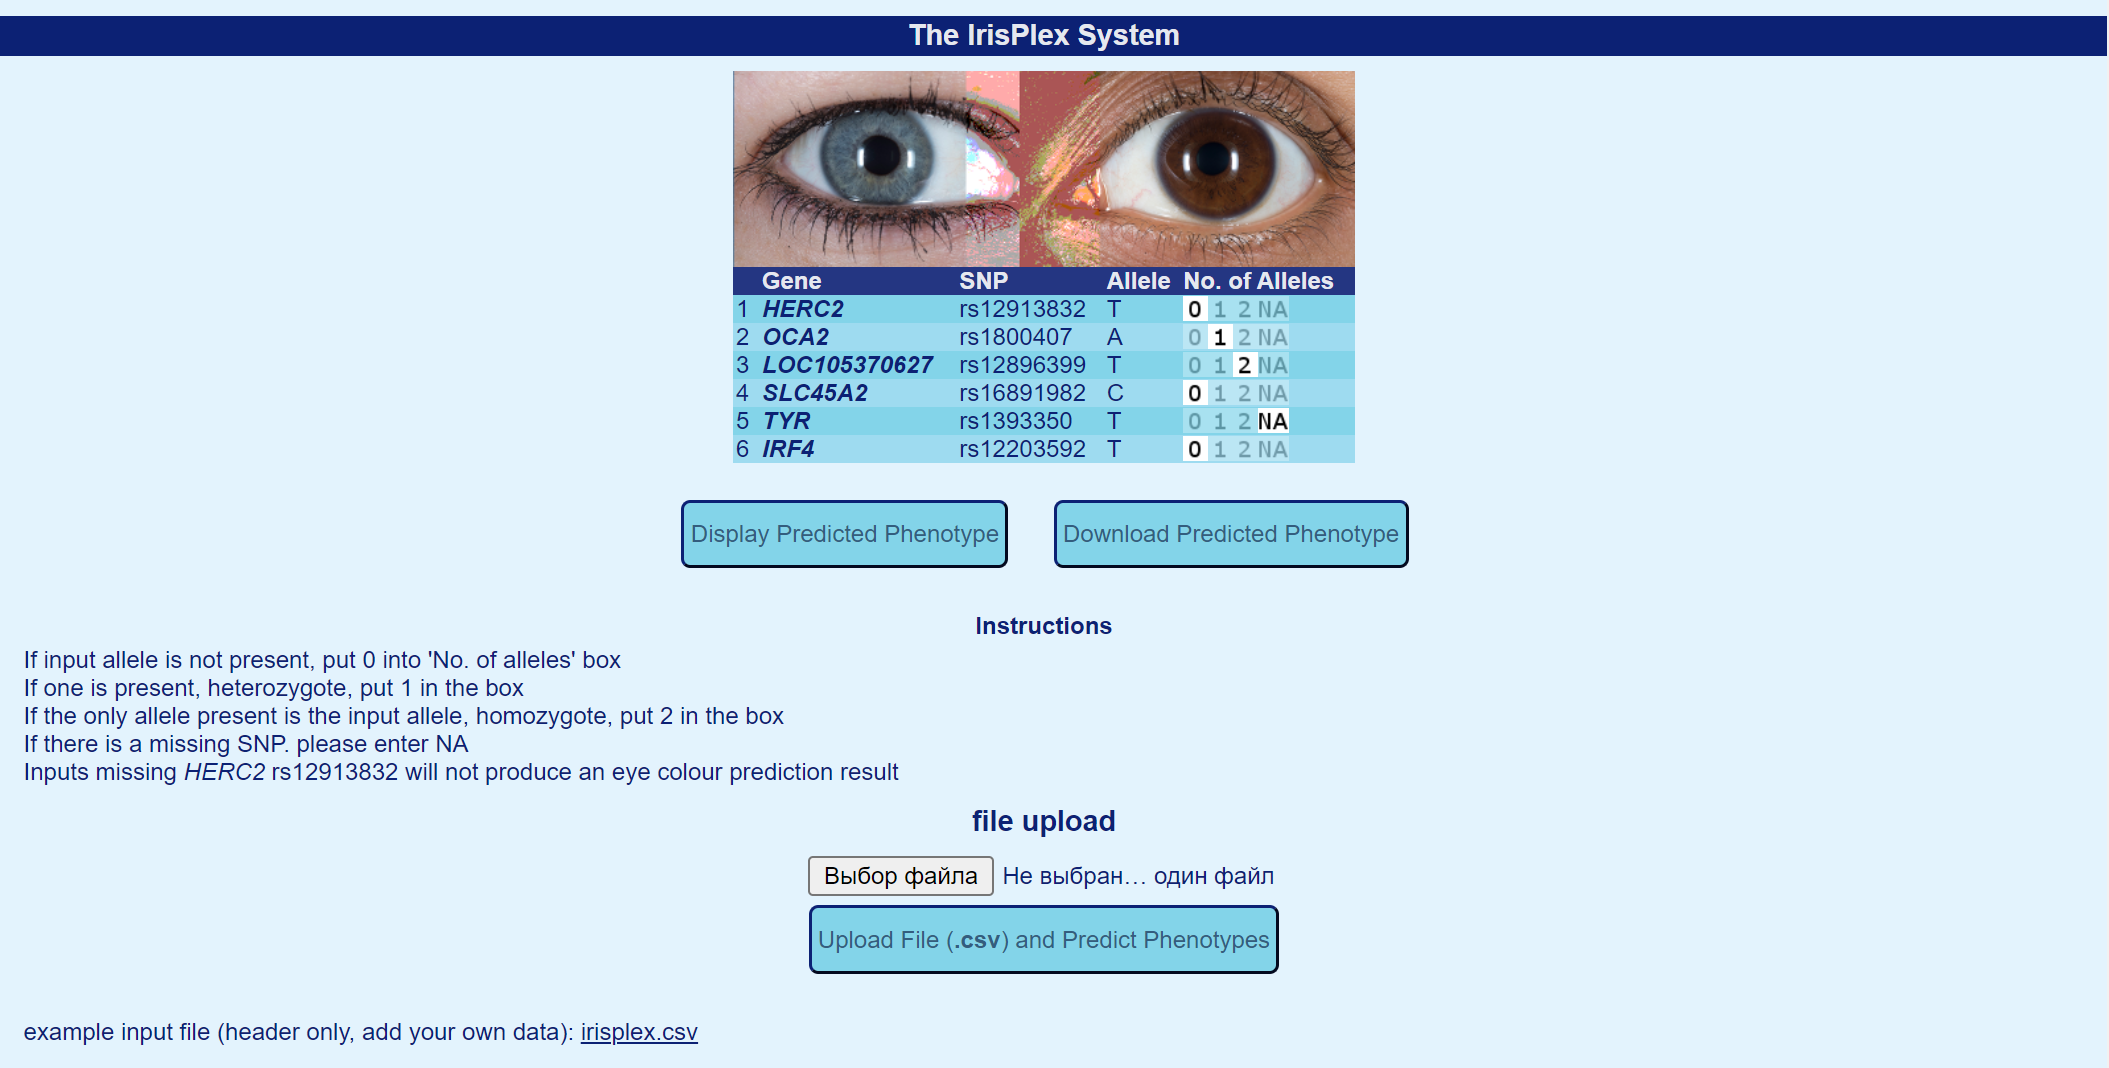

In [35]:
rss = ["rs12913832", "rs1800407", "rs12896399", "rs16891982", "rs1393350", "rs12203592"]

vcf[(vcf["ID"] == rss[0]) | (vcf["ID"] == rss[1]) | (vcf["ID"] == rss[2]) | (vcf["ID"] == rss[3]) | (vcf["ID"] == rss[4]) | (vcf["ID"] == rss[5])]

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,ng1657
190548,chr5,33951693,rs16891982,C,G,.,PASS,.,GT,0/1
219513,chr6,396321,rs12203592,C,T,.,PASS,.,GT,0/0
404195,chr11,89011046,rs1393350,G,A,.,PASS,.,GT,0/0
484734,chr14,92773663,rs12896399,G,T,.,PASS,.,GT,0/0
489619,chr15,28230318,rs1800407,C,T,.,PASS,.,GT,0/0
489656,chr15,28365618,rs12913832,A,G,.,PASS,.,GT,1/1


-/- - 0 если стоит референс значение, 1 - альтернативное. Вбиваем это в таблицу:

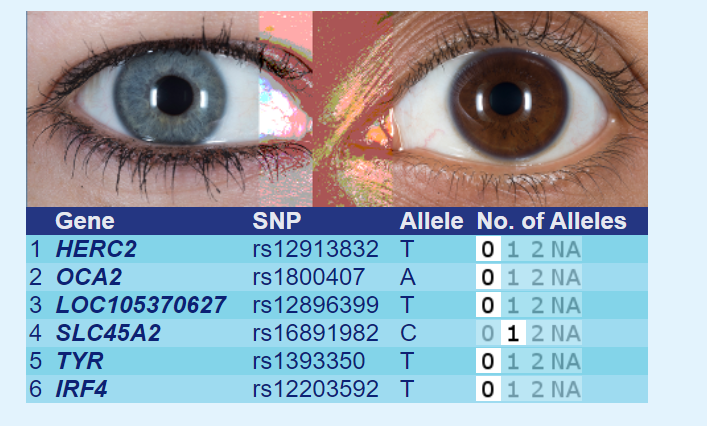

Жмем левую кнопку:

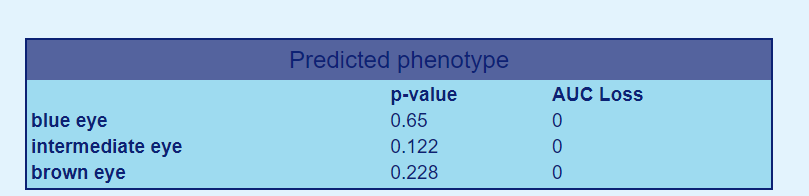

Тут p-value - это вероятность. То есть с вероятностью 65% этот человек с голубыми глазами. В жизни у человека действительно голубые глаза 

(Этот генотип взят с директора генотека, у него для задания 1 был руками изменен ген)

## Задание 3

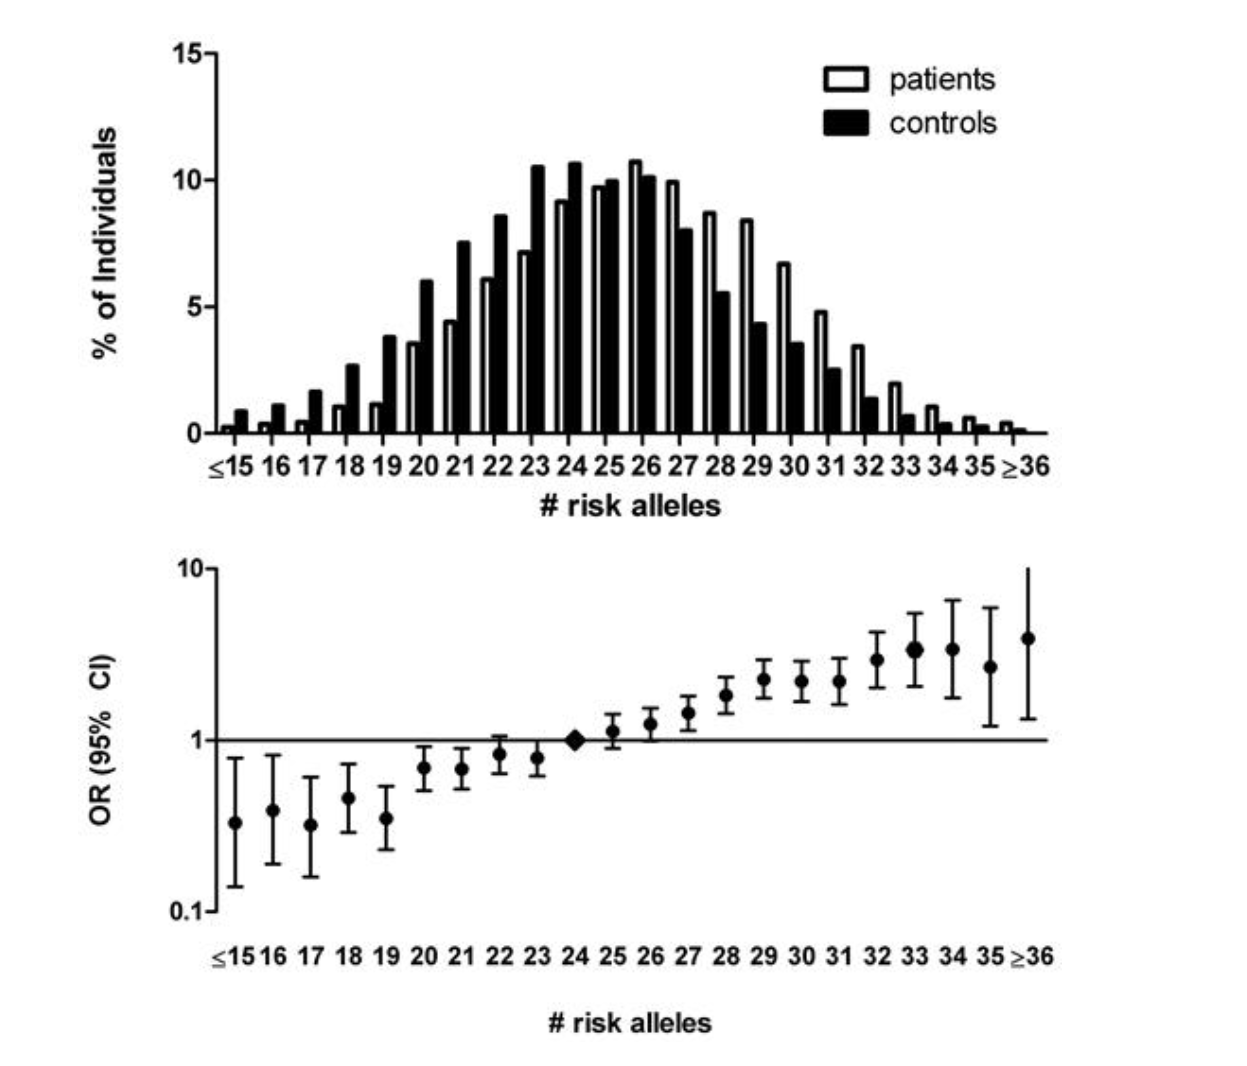

Берем 5 снипов, считаем количество рисковых аллелей. Смотрим на график OR, который показывает, во сколько раз возрастает риск болезни от количества аллелей

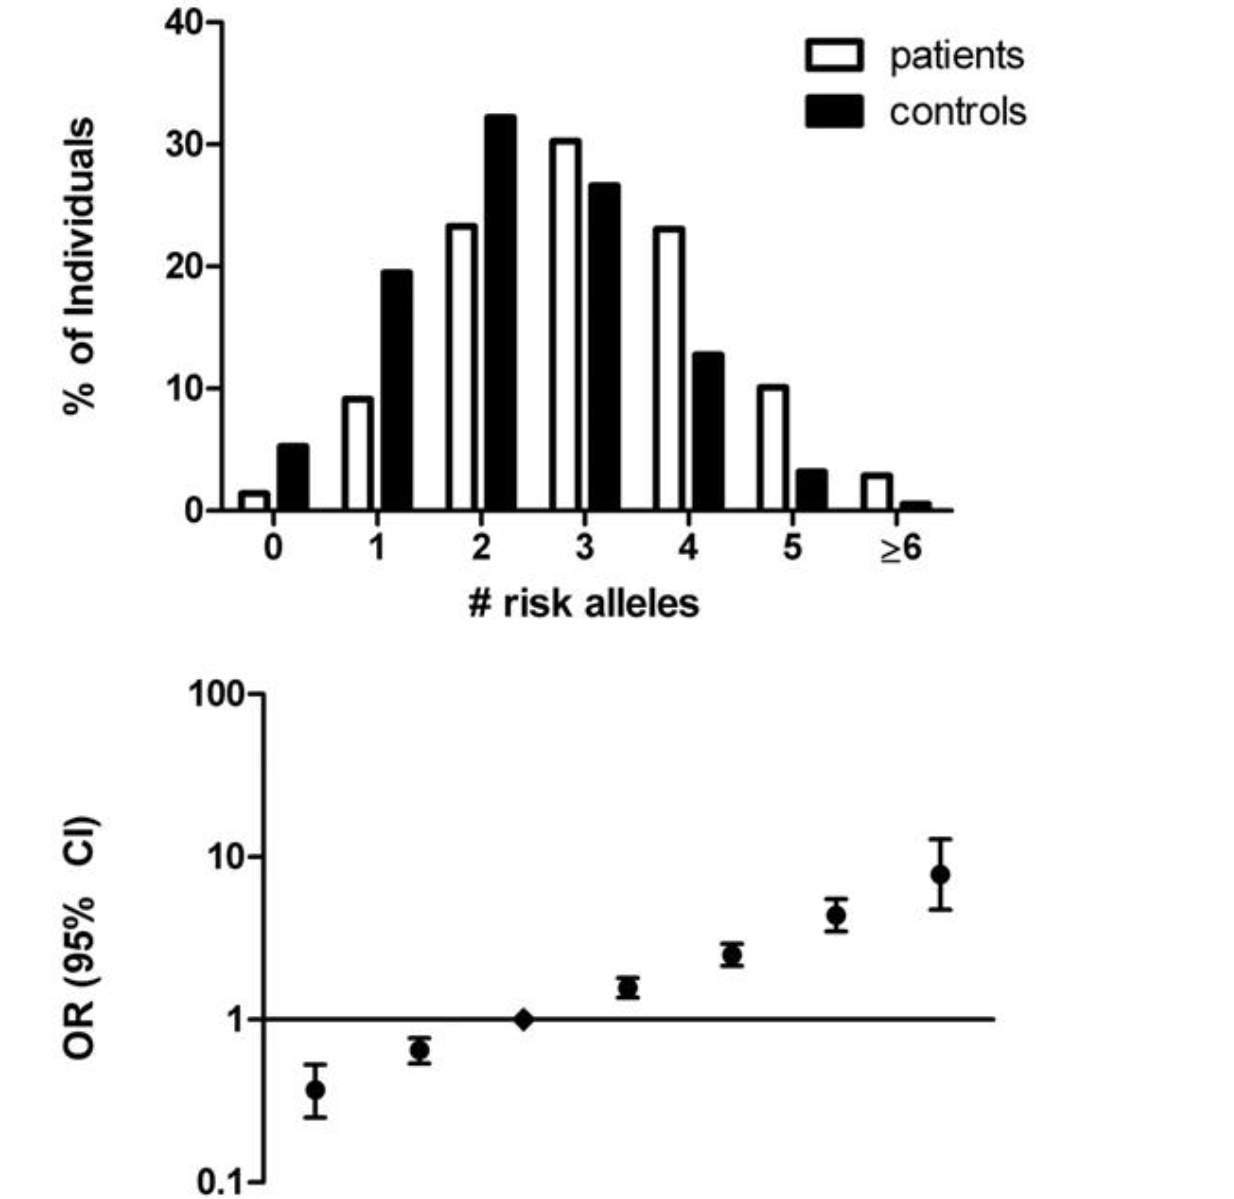

В SNPedia вбиваем по очереди аллели

-  rs6025 - аллель А рисковый. Написано orientation minus - значит, смотрим T

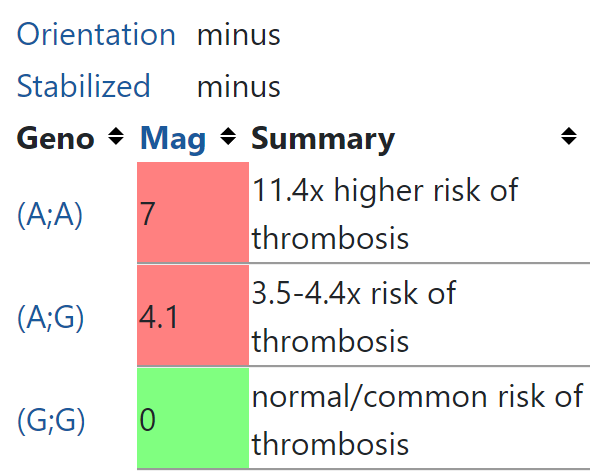

In [37]:
risk_alleles = 0

vcf[vcf["ID"] == "rs6025"] ## 0 рисковых

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,ng1657
31307,chr1,169519049,rs6025,T,C,.,PASS,.,GT,1/1


-  rs1799963 - аллель A рисковый, смотрим А 

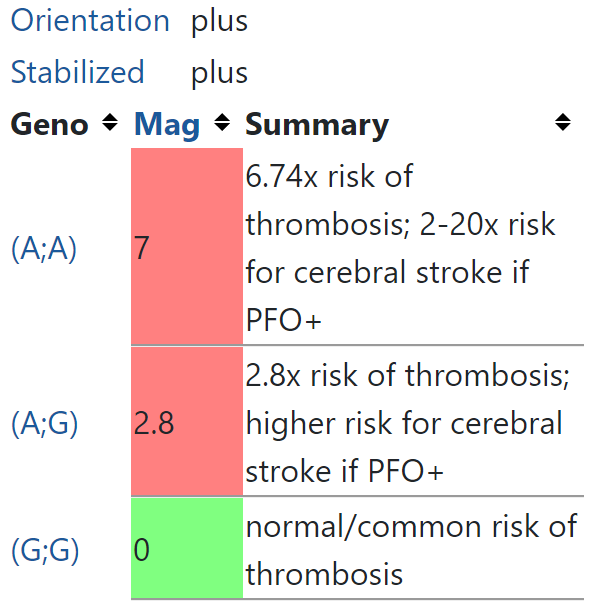

In [38]:
vcf[vcf["ID"] == "rs1799963"] ## 0 

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,ng1657
396069,chr11,46761055,rs1799963,G,A,.,PASS,.,GT,0/0


Для остальных маркеров альтернативный аллель есть рисковый

In [39]:
vcf[vcf["ID"] == "rs8176719"] ## 2

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,ng1657
352333,chr9,136132908,rs8176719,T,TC,.,PASS,.,GT,1/1


Тут инсерт произошел

In [40]:
risk_alleles += 2

vcf[vcf["ID"] == "rs2066865"] ## 0

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,ng1657
174484,chr4,155525276,rs2066865,G,A,.,PASS,.,GT,0/0


In [42]:
vcf[vcf["ID"] == "rs2036914"] ## 1

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,ng1657
181746,chr4,187192481,rs2036914,T,C,.,PASS,.,GT,0/1


In [43]:
risk_alleles += 1
risk_alleles

3

По гистограмме в статье (Figure 3) получили где-то среднее - риск средний для популяции, нет повышенного риска.

Done.